In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn 
import random 
import torchvision
import os
import time
from numpy.core.fromnumeric import squeeze 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn
import random
import sys
sys.path.append("..")
import torch
import torchvision
from torch.optim import LBFGS
import torch.nn.functional as F
from tqdm import tqdm, trange
import seaborn as sns
import os
from torchvision.utils import save_image
from PIL import Image
import cv2
import time

In [2]:
import sys
sys.path.append("..")
# from steganogan.decoders import DenseDecoderNLayers
from steganogan.decoders import BasicDecoder, DenseDecoder, DenseDecoderNLayers
from steganogan import SteganoGAN

In [3]:
def shuffle_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        param = m.weight
        m.weight.data = nn.Parameter(torch.tensor(np.random.normal(0, 1, param.shape)).float())
        
        param = m.bias
        m.bias.data = nn.Parameter(torch.zeros(len(param.view(-1))).float().reshape(param.shape))

        
class normLayer(nn.Module):
    def __init__(self):
        super(normLayer, self).__init__()
    
    def forward(self, x):
        b,c,h,w = x.shape
        assert b == 1
        mean = x.view(c, -1).mean(-1)
        std = x.view(c, -1).std(-1)
        x = x - mean.reshape([1, c, 1, 1])
        x = x / (std + 1e-7).reshape([1,c,1,1])
        return x
    
    
class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        modules = []

        modules.append(self._conv2d(3, self.hidden_size))
        modules.append(nn.LeakyReLU(inplace=True))
        modules.append(normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size))

        for i in range(self.layers-1):
            modules.append(self._conv2d(self.hidden_size, self.hidden_size))
            modules.append(nn.LeakyReLU(inplace=True))
            modules.append(normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size))

        modules.append(self._conv2d(self.hidden_size, self.data_depth))

        self.layers = nn.Sequential(*modules)

        return [self.layers]  
    # 

    def __init__(self, data_depth, hidden_size, layers = 3, yan_norm=False):
        super().__init__()
        self.version = '1'
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self.yan_norm = yan_norm
        self.layers = layers

        self._models = self._build_models()

    def forward(self, x):
        x = self._models[0](x)

        if len(self._models) > 1:
            x_list = [x]
            for layer in self._models[1:]:
                x = layer(torch.cat(x_list, dim=1))
                x_list.append(x)

        return x

In [ ]:
def draw_heatmap():
    conv_layers_list = [1, 3, 5, 7, 9] 
    hidden_size_list = [16, 32, 64, 128, 256]
    # results = np.array([[0.09438404083251956, 0.07557886759440105, 0.03304567972819011, 0.02778354644775391, 0.025574289957682295], \
    #                     [0.05213688761810587, 0.13429681142171224, 0.06048928578694661, 0.03310886383056641, 0.], \
    #                     [0.29246503194173173, 0.21099375406901036, 0.13732290903727212,  0.06579828898111979, 0.], \
    #                     [0.3365685526529948, 0.2721740976969401, 0., 0., 0.], \
    #                     [0.3689719009399415, 0.314051144917806, 0.23975711822509765, 0., 0.]]).transpose((1,0))
    results = np.array([[0.09438404083251956, 0.07557886759440105, 0.03304567972819011, 0.02778354644775391, 0.025574289957682295], \
                    [0.05213688761810587, 0.13429681142171224, 0.06048928578694661, 0.03310886383056641, 0.0038477579752604165], \
                    [0.29246503194173173, 0.21099375406901036, 0.13732290903727212,  0.06579828898111979, 0.018282572428385418], \
                    [0.3365685526529948, 0.2721740976969401, 0.207384401957194, 0.13162740071614584, 0.10343424479166667], \
                    [0.3689719009399415, 0.314051144917806, 0.23975711822509765, 0.19830195109049478, 0.13]]).transpose((1,0))

    ax = sns.heatmap(np.round(results*100, 2), xticklabels=conv_layers_list, yticklabels=hidden_size_list, annot=np.round(results*100, 2))
    plt.xlabel("Depth (num conv layer blocks)")
    plt.ylabel("Width (num hidden units)")
    plt.title("Average percent error rate (3 BPP)")
    plt.savefig('save/FINAL_heatmap_3bits_avg.png', format='png')

    # results = np.array([[0.053972649760646904, 0.07710866521120917, 0.1037003076563209, 0.0930713050693524, 0.07777067795636242], \
    #                     [0.06830002691833212, 0.08308740192594548, 0.0799345894428099, 0.05959464457980756, 0.049686808959701616], \
    #                     [0.060921288328444, 0.08251452049182824, 0.06136291138892486, 0.0443994947219059, 0.040645205266000524], \
    #                     [0.08425474229986253, 0.05257203943881278, 0.05788197389648292, 0.057303367510989675, 0.04768184055913403], \
    #                     [0.05603031322196304, 0.049442282587354815, 0.04777366354922762 , 1, 1]]).transpose((1,0))
    # plt.close()
    # ax = sns.heatmap(results, xticklabels=conv_layers_list, yticklabels=hidden_size_list, annot=np.round(results*100, 2))
    # plt.xlabel("Depth (num conv layer blocks)")
    # plt.ylabel("Width (num hidden units)")
    # plt.title("Percentage error bits (4 bits, std)")
    # plt.savefig('save/save_heatmap_4bits_std.png', format='png')

In [4]:
# JPEG definition
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def gen_filters(size_x: int, size_y: int, dct_or_idct_fun: callable) -> np.ndarray:
    tile_size_x = 8
    filters = np.zeros((size_x * size_y, size_x, size_y))
    for k_y in range(size_y):
        for k_x in range(size_x):
            for n_y in range(size_y):
                for n_x in range(size_x):
                    filters[k_y * tile_size_x + k_x, n_y, n_x] = dct_or_idct_fun(n_y, k_y, size_y) * dct_or_idct_fun(n_x,
                                                                                                            k_x,
                                                                                                            size_x)
    return filters

# def zigzag_indices(shape: (int, int), count):
#     x_range, y_range = shape
#     index_order = sorted(((x, y) for x in range(x_range) for y in range(y_range)),
#                          key=lambda p: (p[0] + p[1], -p[1] if (p[0] + p[1]) % 2 else p[1]))
#
#     mask = np.zeros(shape)
#     for r, c in index_order[:count]:
#         mask[r,c] = 1
#
#     return mask

def get_jpeg_yuv_filter_mask(image_shape: tuple, window_size: int, keep_count: int):
    mask = np.zeros((window_size, window_size), dtype=np.uint8)

    index_order = sorted(((x, y) for x in range(window_size) for y in range(window_size)),
                         key=lambda p: (p[0] + p[1], -p[1] if (p[0] + p[1]) % 2 else p[1]))

    for i, j in index_order[0:keep_count]:
        mask[i, j] = 1

    return np.tile(mask, (int(np.ceil(image_shape[0] / window_size)),
                          int(np.ceil(image_shape[1] / window_size))))[0: image_shape[0], 0: image_shape[1]]


def dct_coeff(n, k, N):
    return np.cos(np.pi / N * (n + 1. / 2.) * k)


def idct_coeff(n, k, N):
    return (int(0 == n) * (- 1 / 2) + np.cos(
        np.pi / N * (k + 1. / 2.) * n)) * np.sqrt(1 / (2. * N))


def rgb2yuv(image_rgb, image_yuv_out):
    """ Transform the image from rgb to yuv """
    image_yuv_out[:, 0, :, :] = 0.299 * image_rgb[:, 0, :, :].clone() + 0.587 * image_rgb[:, 1, :, :].clone() + 0.114 * image_rgb[:, 2, :, :].clone()
    image_yuv_out[:, 1, :, :] = -0.14713 * image_rgb[:, 0, :, :].clone() + -0.28886 * image_rgb[:, 1, :, :].clone() + 0.436 * image_rgb[:, 2, :, :].clone()
    image_yuv_out[:, 2, :, :] = 0.615 * image_rgb[:, 0, :, :].clone() + -0.51499 * image_rgb[:, 1, :, :].clone() + -0.10001 * image_rgb[:, 2, :, :].clone()


def yuv2rgb(image_yuv, image_rgb_out):
    """ Transform the image from yuv to rgb """
    image_rgb_out[:, 0, :, :] = image_yuv[:, 0, :, :].clone() + 1.13983 * image_yuv[:, 2, :, :].clone()
    image_rgb_out[:, 1, :, :] = image_yuv[:, 0, :, :].clone() + -0.39465 * image_yuv[:, 1, :, :].clone() + -0.58060 * image_yuv[:, 2, :, :].clone()
    image_rgb_out[:, 2, :, :] = image_yuv[:, 0, :, :].clone() + 2.03211 * image_yuv[:, 1, :, :].clone()


class JpegCompression(nn.Module):
    def __init__(self, device, yuv_keep_weights = (25, 9, 9)):
        super(JpegCompression, self).__init__()
        self.device = device

        self.dct_conv_weights = torch.tensor(gen_filters(8, 8, dct_coeff), dtype=torch.float32).to(self.device)
        self.dct_conv_weights.unsqueeze_(1)
        self.idct_conv_weights = torch.tensor(gen_filters(8, 8, idct_coeff), dtype=torch.float32).to(self.device)
        self.idct_conv_weights.unsqueeze_(1)

        self.yuv_keep_weighs = yuv_keep_weights
        self.keep_coeff_masks = []

        self.jpeg_mask = None

        # create a new large mask which we can use by slicing for images which are smaller
        self.create_mask((1000, 1000))


    def create_mask(self, requested_shape):
        if self.jpeg_mask is None or requested_shape > self.jpeg_mask.shape[1:]:
            self.jpeg_mask = torch.empty((3,) + requested_shape, device=self.device)
            for channel, weights_to_keep in enumerate(self.yuv_keep_weighs):
                mask = torch.from_numpy(get_jpeg_yuv_filter_mask(requested_shape, 8, weights_to_keep))
                self.jpeg_mask[channel] = mask

    def get_mask(self, image_shape):
        if self.jpeg_mask.shape < image_shape:
            self.create_mask(image_shape)
        # return the correct slice of it
        return self.jpeg_mask[:, :image_shape[1], :image_shape[2]].clone()


    def apply_conv(self, image, filter_type: str):

        if filter_type == 'dct':
            filters = self.dct_conv_weights
        elif filter_type == 'idct':
            filters = self.idct_conv_weights
        else:
            raise('Unknown filter_type value.')

        image_conv_channels = []
        for channel in range(image.shape[1]):
            image_yuv_ch = image[:, channel, :, :].unsqueeze_(1)
            image_conv = F.conv2d(image_yuv_ch, filters, stride=8)
            image_conv = image_conv.permute(0, 2, 3, 1)
            image_conv = image_conv.view(image_conv.shape[0], image_conv.shape[1], image_conv.shape[2], 8, 8)
            image_conv = image_conv.permute(0, 1, 3, 2, 4)
            image_conv = image_conv.contiguous().view(image_conv.shape[0],
                                                  image_conv.shape[1]*image_conv.shape[2],
                                                  image_conv.shape[3]*image_conv.shape[4])

            image_conv.unsqueeze_(1)

            # image_conv = F.conv2d()
            image_conv_channels.append(image_conv)

        image_conv_stacked = torch.cat(image_conv_channels, dim=1)

        return image_conv_stacked


    def forward(self, noised_and_cover):
        with torch.autograd.set_detect_anomaly(True):
            noised_image = noised_and_cover[0]
            # pad the image so that we can do dct on 8x8 blocks
            pad_height = (8 - noised_image.shape[2] % 8) % 8
            pad_width = (8 - noised_image.shape[3] % 8) % 8

            noised_image = nn.ZeroPad2d((0, pad_width, 0, pad_height))(noised_image)

            # convert to yuv
            image_yuv = torch.empty_like(noised_image)
            rgb2yuv(noised_image, image_yuv)

            assert image_yuv.shape[2] % 8 == 0
            assert image_yuv.shape[3] % 8 == 0

            # apply dct
            image_dct = self.apply_conv(image_yuv, 'dct')
            # get the jpeg-compression mask
            mask = self.get_mask(image_dct.shape[1:])
            # multiply the dct-ed image with the mask.
            image_dct_mask = torch.mul(image_dct, mask)

            # apply inverse dct (idct)
            image_idct = self.apply_conv(image_dct_mask, 'idct')
            # transform from yuv to to rgb
            image_ret_padded = torch.empty_like(image_dct)
            yuv2rgb(image_idct, image_ret_padded)

            # un-pad
            noised_and_cover[0] = image_ret_padded[:, :, :image_ret_padded.shape[2]-pad_height, :image_ret_padded.shape[3]-pad_width].clone()

        return noised_and_cover

In [5]:
num_bits = 3
dir = "/home/vk352/FaceDetection/datasets/test_set_512"
num_imgs = 1
steps = 2000
eps = 0.3
yan_norm = False
max_iter = 20
alpha = 0.1
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
# conv_layers_list = [1, 3, 5, 7, 9] 
conv_layers_list = [3] 
hidden_size_list = [16]
# hidden_size_list = [16, 32, 64, 128, 256]
# hidden_size_list = [16, 32, 64]
results_avg = np.ones((len(conv_layers_list), len(hidden_size_list)))
results_std = np.ones((len(conv_layers_list), len(hidden_size_list)))

In [6]:
# for layer_size_i in range(len(conv_layers_list)):
#     for hidden_size_i in range(len(hidden_size_list)):
#         print('### {} {} ###'.format(conv_layers_list[layer_size_i], hidden_size_list[hidden_size_i]))
#         sum_final_err = []
#         model = BasicDecoder(num_bits, hidden_size=hidden_size_list[hidden_size_i], layers=conv_layers_list[layer_size_i], yan_norm=yan_norm)
#         for img_i in range(num_imgs):
#             # seed = random.randrange(sys.maxsize) % (2**32 - 1)

#             np.random.seed(img_i)
#             model.apply(shuffle_params)
#             model.to('cuda')
#             filename = os.listdir(dir)[img_i]
#             image = "{}/{}".format(dir, filename)
#             image = imread(image, pilmode='RGB') / 255.0
#             image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
#             image = image.to('cuda')
#             out = model(image)

#             torch.manual_seed(img_i)
#             target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
#             # print(target.shape)

#             adv_image = image.clone().detach()
#             end = time.time()
#             for i in range(steps // max_iter):
#                 adv_image.requires_grad = True
#                 optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

#                 def closure():
#                     outputs = model(adv_image)
#                     loss = criterion(outputs, target)

#                     optimizer.zero_grad()
#                     loss.backward()
#                     return loss

#                 optimizer.step(closure)
#                 delta = torch.clamp(adv_image - image, min=-eps, max=eps)
#                 adv_image = torch.clamp(image + delta, min=0, max=1).detach()

#                 err = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()

#                 if err==0: break
#             print('@@@time={}'.format(time.time()-end))

In [22]:
layer_size_i = 0
hidden_size_i = 0
print('### {} {} ###'.format(conv_layers_list[layer_size_i], hidden_size_list[hidden_size_i]))
sum_final_err = []
model = BasicDecoder(num_bits, hidden_size=hidden_size_list[hidden_size_i], layers=conv_layers_list[layer_size_i], yan_norm=yan_norm)
for img_i in range(num_imgs):
    # seed = random.randrange(sys.maxsize) % (2**32 - 1)
    np.random.seed(img_i)
    model.apply(shuffle_params)
    model.to('cuda')
    filename = os.listdir(dir)[img_i]
    image = "{}/{}".format(dir, filename)
    image = imread(image, pilmode='RGB') / 255.0
    image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
    image = image.to('cuda')
    out = model(image)

    torch.manual_seed(img_i)
    target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
    # print(target.shape)

    adv_image = image.clone().detach()
    end = time.time()
    for i in range(steps // max_iter):
        adv_image.requires_grad = True
        optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

        def closure():
            # pos 1
            outputs = model(adv_image)
            loss = criterion(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1).detach()

        err = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()

        if err==0: break
    print('@@@time={}'.format(time.time()-end))

### 3 16 ###
@@@time=56.86236119270325


0.24181111653645834

In [44]:
err

0.24181111653645834

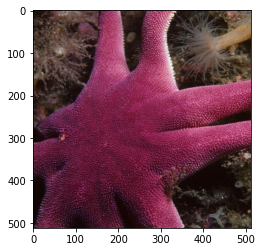

In [42]:
adv_image.shape
import matplotlib.pyplot as plt
plt.imshow(image[0].permute(1,2,0).cpu().numpy())

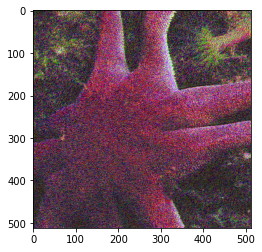

In [41]:
plt.imshow(adv_image[0].permute(1,2,0).cpu().numpy())